# Initial setup

Importing all required libraries and loading the data

In [189]:
# Import Modules
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import csv
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import datetime

FILE_NAME = 'information.csv'

input_data = pd.read_csv(FILE_NAME)
display(input_data.head(5))

,customer_id,First Time,Recent Time,# of Orders,# of Orders in last 7 days,# of Orders in last 4 weeks,Amount,Amount in last 7 days,Amount in last 4 weeks,Avg_DistanceFromResturant,Avg_DeliveryTime
0,1269647,6/29/15 10:57,12/10/15 2:18,212,6.0,43.0,138808,4291,26853,1.6,51
1,167631,7/4/15 15:39,12/15/15 14:42,211,8.0,19.0,56404,1925,4177,2.2,42
2,301524,6/26/15 9:56,12/9/15 20:45,189,9.0,33.0,36020,1772,6404,2.5,57
3,1268254,7/1/15 1:51,12/14/15 1:43,184,6.0,37.0,32489,975,7110,3.1,55
4,357161,7/11/15 18:34,12/19/15 23:26,182,4.0,23.0,85150,1738,9958,2.4,36


### Feature Engineering
1. This part helps to get the count of the values of the input data.
2. Added Four Derived Attributes (customer_duration, customer_recency, Avg_Ticket_Value, Customer_Value) to make the feature slection process easier
#### customer_duration
This signifies how much time customer is accustomed with the platform.
#### customer_recency
This signifies the time difference of last order of the data.
#### Avg_Ticket_Value
This signifies the avg spending pattern of the user
#### Customer_Value
This signifies that week by week spending is decreasing or increasing. If spending increases customer value increases and if it decreases then customer value is decreasing.

In [232]:
print("Number of rows: ",input_data.shape[0])
counts = input_data.describe().iloc[0]
display(
    pd.DataFrame(
        counts.tolist(), 
        columns=["Count of values"], 
        index=counts.index.values
    ).transpose()
)

input_data['First Time']=pd.to_datetime(input_data['First Time'], infer_datetime_format=True)
input_data['Recent Time']=pd.to_datetime(input_data['Recent Time'], infer_datetime_format=True)
input_data['customer_duration'] = input_data.apply(lambda x: (datetime.date.today()-x['First Time'].date()).days, axis=1)
input_data['customer_recency'] = input_data.apply(lambda x: (datetime.date.today()-x['Recent Time'].date()).days, axis=1)
input_data['Avg_Ticket_Value'] = input_data['Amount']*1.0/input_data['# of Orders']
input_data['Customer_Value'] = input_data['Amount in last 7 days'] - (input_data['Amount in last 4 weeks']*1.0/4)

('Number of rows: ', 10000)


,customer_id,# of Orders,# of Orders in last 7 days,# of Orders in last 4 weeks,Amount,Amount in last 7 days,Amount in last 4 weeks,Avg_DistanceFromResturant,Avg_DeliveryTime,customer_duration,...,Amount_,Amount_in_last_7_days,Amount_in_last_4_weeks,Avg_DistanceFromResturant_,Avg_DeliveryTime_,duration,recency,Avg_Ticket_Value,Avg_Ticket_Value_,Customer_Value
Count of values,10000.0,10000.0,1923.0,4341.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,...,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0


### Feature Selection
Used __SVD__ to remove redundant feature.
1. Prior That  data standardization have been done
2. value = value-min/max-min has been applied to standardize that though Recency weightage should have been calculated seperately in reverse manner (that has been done below)
3. Selection of columns has been done based on _svd components_

In [234]:

input_data['#_of_Orders']=(input_data['# of Orders']-input_data['# of Orders'].min()*1.0)/(input_data['# of Orders'].max()-input_data['# of Orders'].min())
input_data['#_of_Orders_in_last_7_days']=(input_data['# of Orders in last 7 days']-input_data['# of Orders in last 7 days'].min()*1.0)/(input_data['# of Orders in last 7 days'].max()-input_data['# of Orders in last 7 days'].min())
input_data['#_of_Orders_in_last_4_weeks']=(input_data['# of Orders in last 4 weeks']-input_data['# of Orders in last 4 weeks'].min()*1.0)/(input_data['# of Orders in last 4 weeks'].max()-input_data['# of Orders in last 4 weeks'].min())
input_data['Amount_']=(input_data['Amount']-input_data['Amount'].min()*1.0)/(input_data['Amount'].max()-input_data['Amount'].min())
input_data['Amount_in_last_7_days']=(input_data['Amount in last 7 days']-input_data['Amount in last 7 days'].min()*1.0)/(input_data['Amount in last 7 days'].max()-input_data['Amount in last 7 days'].min())
input_data['Amount_in_last_4_weeks']=(input_data['Amount in last 4 weeks']-input_data['Amount in last 4 weeks'].min()*1.0)/(input_data['Amount in last 4 weeks'].max()-input_data['Amount in last 4 weeks'].min())
input_data['Avg_DistanceFromResturant_']=(input_data['Avg_DistanceFromResturant']-input_data['Avg_DistanceFromResturant'].min()*1.0)/(input_data['Avg_DistanceFromResturant'].max()-input_data['Avg_DistanceFromResturant'].min())
input_data['Avg_DeliveryTime_']=(input_data['Avg_DeliveryTime']-input_data['Avg_DeliveryTime'].min()*1.0)/(input_data['Avg_DeliveryTime'].max()-input_data['Avg_DeliveryTime'].min())
input_data['duration']=(input_data['customer_duration']-input_data['customer_duration'].min()*1.0)/(input_data['customer_duration'].max()-input_data['customer_duration'].min())
input_data['recency']=(input_data['customer_recency']-input_data['customer_recency'].min()*1.0)/(input_data['customer_recency'].max()-input_data['customer_recency'].min())
input_data['Avg_Ticket_Value_'] = (input_data['Avg_Ticket_Value']-input_data['Avg_Ticket_Value'].min()*1.0)/(input_data['Avg_Ticket_Value'].max()-input_data['Avg_Ticket_Value'].min())
input_data['Customer_Value_'] = (input_data['Customer_Value']-input_data['Customer_Value'].min()*1.0)/(input_data['Customer_Value'].max()-input_data['Customer_Value'].min())

In [235]:
from sklearn.decomposition import TruncatedSVD
dataframe = input_data[['#_of_Orders','#_of_Orders_in_last_7_days','#_of_Orders_in_last_4_weeks','Amount_','Amount_in_last_7_days','Amount_in_last_4_weeks','Avg_DistanceFromResturant_','Avg_DeliveryTime_','duration','recency','Avg_Ticket_Value_','Customer_Value_']]
svd = TruncatedSVD(n_components=9, n_iter=15, random_state=42)
dataframe=dataframe.dropna()
svd.fit(dataframe.values.tolist()) 
#print(svd.explained_variance_ratio_)
var_ratios=svd.explained_variance_ratio_
#print(svd.singular_values_)
display( "get the dimensions coeff" 
" ".join([
    "%+0.3f*%s" % (coef, feat) 
    for coef, feat in zip(svd.components_[0], dataframe.columns)
]))

'+0.089*#_of_Ordersget the dimensions coeff +0.064*#_of_Orders_in_last_7_daysget the dimensions coeff +0.093*#_of_Orders_in_last_4_weeksget the dimensions coeff +0.045*Amount_get the dimensions coeff +0.061*Amount_in_last_7_daysget the dimensions coeff +0.062*Amount_in_last_4_weeksget the dimensions coeff +0.482*Avg_DistanceFromResturant_get the dimensions coeff +0.336*Avg_DeliveryTime_get the dimensions coeff +0.627*durationget the dimensions coeff +0.145*recencyget the dimensions coeff +0.035*Avg_Ticket_Value_get the dimensions coeff +0.457*Customer_Value_'

Based on __SVD__ From This data set following columns has been selected 
1. #_of_Orders
3. #_of_Orders_in_last_4_weeks
4. Avg_DistanceFromResturant
5. Avg_DeliveryTime
6. customer_duration
7. customer_recency 

Here #_of_Orders_in_last_4_weeks contains NA, Based on Perception, if no order data available we can can consider that no order has been placed in that period.
P.S - Refinement can be done, based on Amount (if amount==0 then order 0 else, populate based on Avg ticket value)

# Feature Selection
Based on variance results we will select 
1. No of Orders
3. No of Orders in last 4 weeks
4. Avg_DistanceFromResturant
5. Avg_DeliveryTime
6. customer_duration
7. customer_recency

For further analysis

In [236]:
finaldataframe = input_data[['customer_id','#_of_Orders','#_of_Orders_in_last_4_weeks','Avg_DistanceFromResturant','Avg_DeliveryTime','customer_duration','customer_recency','Customer_Value']]
print "Columns Having None :",finaldataframe.columns[finaldataframe.isna().any()].tolist()
finaldataframe=finaldataframe.fillna(0)

Columns Having None : ['#_of_Orders_in_last_4_weeks']


In [237]:
finaldataframe.shape

(10000, 8)

In [238]:
finaldataframe.head()

,customer_id,#_of_Orders,#_of_Orders_in_last_4_weeks,Avg_DistanceFromResturant,Avg_DeliveryTime,customer_duration,customer_recency,Customer_Value
0,1269647,1.000000,0.933333,1.6,51,1191,1027,-2422.25
1,167631,0.995261,0.400000,2.2,42,1186,1022,880.75
2,301524,0.890995,0.711111,2.5,57,1194,1028,171.00
3,1268254,0.867299,0.800000,3.1,55,1189,1023,-802.50
4,357161,0.857820,0.488889,2.4,36,1179,1018,-751.50


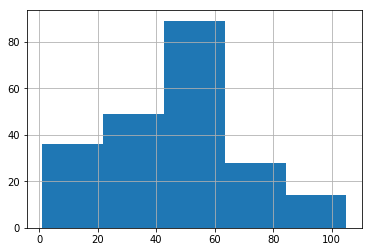

In [208]:
finaldataframe.customer_id.groupby(finaldataframe.customer_duration).nunique().hist(bins=5);

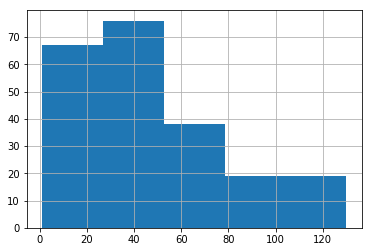

In [210]:
finaldataframe.customer_id.groupby(finaldataframe.customer_recency).nunique().hist(bins=5);

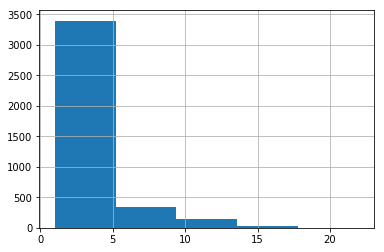

In [98]:
finaldataframe.customer_id.groupby(finaldataframe.Amount).nunique().hist(bins=5);

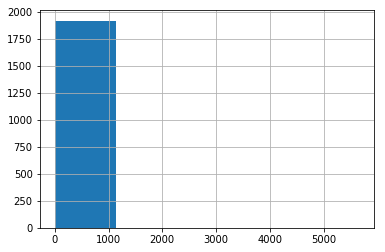

In [99]:
finaldataframe.customer_id.groupby(finaldataframe.Amount_in_last_4_weeks).nunique().hist(bins=5);

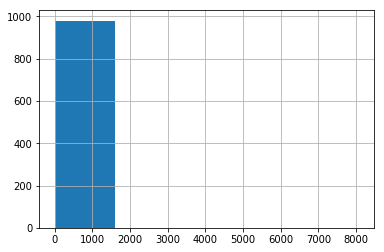

In [100]:
finaldataframe.customer_id.groupby(finaldataframe.Amount_in_last_7_days).nunique().hist(bins=5);

# Clustering of the Users

Optimal value of k has been found using __elbow method__ to determine optimal value of k

In [239]:
finaldataframe = input_data[['#_of_Orders','#_of_Orders_in_last_4_weeks','Avg_DistanceFromResturant','Avg_DeliveryTime','customer_duration','customer_recency','Customer_Value']]
print "Columns Having None :",finaldataframe.columns[finaldataframe.isna().any()].tolist()
finaldataframe=finaldataframe.fillna(0)

Columns Having None : ['#_of_Orders_in_last_4_weeks']


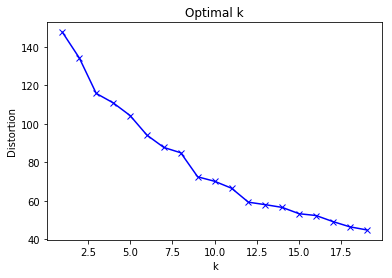

In [240]:
data_x = finaldataframe.values
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(data_x)
    kmeanModel.fit(data_x)
    distortions.append(sum(np.min(cdist(data_x, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / data_x.shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Optimal k')
plt.show()

In [241]:
FINAL_K = 12
kmeanModel = KMeans(n_clusters=FINAL_K).fit(data_x)

In [242]:
customer_labels = kmeanModel.labels_

In [244]:
finaldataframe = input_data[['customer_id','# of Orders','# of Orders in last 4 weeks','Avg_DistanceFromResturant','Avg_DeliveryTime','customer_duration','customer_recency','Avg_Ticket_Value','Customer_Value']]

In [245]:
rows = finaldataframe.shape[0]

In [246]:
finaldataframe['cluster_id']=customer_labels

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [247]:
j=finaldataframe.groupby(['cluster_id']).size()*100.0/finaldataframe.shape[0]
j=j.reset_index()
print j

    cluster_id      0
0            0  31.04
1            1   0.93
2            2   0.69
3            3   2.16
4            4   0.03
5            5   2.64
6            6  27.21
7            7   0.17
8            8   0.08
9            9   9.16
10          10   5.94
11          11  19.95


In [253]:
finaldataframe=finaldataframe.fillna(0)
finaldataframe['recency']=(finaldataframe.customer_recency.max()-finaldataframe['customer_recency'])*1.0/abs(finaldataframe.customer_recency.min()-finaldataframe.customer_recency.max())
finaldataframe['duration']=(finaldataframe['customer_duration']-finaldataframe.customer_duration.min())*1.0/abs(finaldataframe.customer_duration.min()-finaldataframe.customer_duration.max())
user_segmenst=finaldataframe.groupby(['cluster_id'])['# of Orders','# of Orders in last 4 weeks','duration','recency','Avg_Ticket_Value','Customer_Value'].agg(['size','mean','median'])

In [254]:
user_segmenst.reset_index()

cluster_id # of Orders                   # of Orders in last 4 weeks  \
                     size       mean median                        size   
0           0        3104   2.328608      1                        3104   
1           1          93  17.268817      6                          93   
2           2          69  30.420290     22                          69   
3           3         216  15.148148      8                         216   
4           4           3  48.333333     33                           3   
5           5         264  24.147727     13                         264   
6           6        2721   2.402058      1                        2721   
7           7          17  20.941176     15                          17   
8           8           8  45.500000     20                           8   
9           9         916  11.448690      6                         916   
10         10         594  10.794613      5                         594   
11         11        1995  12.622556      8                        1995   

                     duration                     recency                      \
         mean median     size      mean    median    size      mean    median   
0    0.643041    0.0     3104  0.339232  0.351852    3104  0.702470  0.703196   
1    5.193548    3.0       93  0.519713  0.495370      93  0.857760  0.853881   
2    8.768116    7.0       69  0.658481  0.740741      69  0.831381  0.831050   
3    4.000000    3.0      216  0.540166  0.643519     216  0.861682  0.867580   
4   10.666667    9.0        3  0.666667  0.870370       3  0.873668  0.867580   
5    6.117424    4.0      264  0.633523  0.729167     264  0.819185  0.826484   
6    0.000000    0.0     2721  0.720146  0.722222    2721  0.329902  0.337900   
7    7.470588    3.0       17  0.611928  0.671296      17  0.843943  0.840183   
8   13.000000    9.5        8  0.543981  0.569444       8  0.833904  0.831050   
9    3.183406    2.0      916  0.527338  0.555556     916  0.813782  0.817352   
10   3.146465    2.0      594  0.495807  0.520833     594  0.860969  0.863014   
11   1.639098    1.0     1995  0.770482  0.782407    1995  0.739973  0.748858   

   Avg_Ticket_Value                           Customer_Value               \
               size         mean       median           size         mean   
0              3104   315.455017   229.000000           3104   -10.435325   
1                93   740.840805   628.276596             93  1215.645161   
2                69   773.410676   672.971429             69 -1152.797101   
3               216   547.321328   496.900000            216   611.097222   
4                 3  2109.159596   852.606061              3  5927.500000   
5               264   638.679756   541.637500            264  -553.106061   
6              2721   359.758632   281.000000           2721     0.000000   
7                17  1361.537628   827.428571             17  2371.426471   
8                 8  3212.465970  1292.164835              8 -3028.968750   
9               916   485.821514   448.625000            916  -210.227347   
10              594   339.197706   304.692308            594   249.835859   
11             1995   266.273467   211.333333           1995   -10.300752   

              
      median  
0      0.000  
1   1157.250  
2  -1083.250  
3    572.500  
4   6391.500  
5   -528.375  
6      0.000  
7   2305.250  
8  -2594.000  
9   -198.750  
10   234.750  
11     0.000

In [143]:
abs(finaldataframe.customer_duration.min()-finaldataframe.customer_duration.max())

216

In [145]:
abs(finaldataframe.customer_recency.min())

993

In [158]:
x=finaldataframe[finaldataframe['cluster_id']==1]

In [160]:
x.Amount_in_last_7_days.median()

0.0